# Name Entity Recognition

In [1]:
!pip install transformers datasets seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 17.9 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=cc9ce7e89fcf18f59cc50dd3b64b50494769e71e635d8f5acbe4a5dabfd8d94b
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-

In [2]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 7.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

## Imports

In [3]:

import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import shutil
import torch
from collections import Counter, defaultdict
from datasets import load_dataset, ClassLabel
from seqeval.metrics import classification_report, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.nn.functional import cross_entropy
from torch.optim import AdamW
from torch.utils.data import DataLoader, SubsetRandomSampler
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification, AutoConfig,
    DataCollatorForTokenClassification,
    TrainingArguments, Trainer, get_scheduler
)
from wordcloud import WordCloud

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls /content/drive/MyDrive/NLP_Ensae/

 bert-base-cased.ipynb		   'Descriptive analysis.ipynb'   xlm-roberta-base.ipynb
'camembert camembert-large.ipynb'   distilbert-base-cased.ipynb
 CamemBERT.ipynb		    entities.json


## Data Processing

As our task essentially involves named entity recognition, the first step is to format the data according to the required specifications. For instance, we will fine-tune the pre-trained Bert and Camembert models for such a task. These models take input data in the format below, so we need to preprocess our dataset to fit this format.

```
{
  "tokens": ["NGUIMATSIA", "TIOFACK", "Franki","enfant", "etudiant", "25", "Français", "néant"],
  "ner_tags": ["B-surname", "I-surname", "B-firstname", "B-occupation", "B-age", "B-nationality", "O"]
}
```

In [6]:
import json
import pandas as pd
with open("/content/drive/MyDrive/NLP_Ensae/entities.json", 'r') as f:
    data = json.load(f)
df = pd.DataFrame([data])


In [7]:
entity_without_indi = {
    0: "O",
    1: 'surname_household',
    2: 'firstname',
    3: 'occupation',
    4: 'link',
    5: 'birth_date',
    6: 'nationality',
    7: 'lob',
    8: 'age',
    9: 'civil_status',
    10: 'employer',
    11: 'observation',
    12: 'surname'}

In [8]:
entity_map = {
    'Ⓟ': 'surname_household',
    'Ⓕ': 'firstname',
    'Ⓜ': 'occupation',
    'Ⓗ': 'link',
    'Ⓑ': 'birth_date',
    'Ⓚ': 'nationality',
    'Ⓘ': 'lob',
    'Ⓐ': 'age',
    'Ⓒ': 'civil_status',
    'Ⓔ': 'employer',
    'Ⓛ': 'observation',
    'Ⓞ': 'surname'}

In [9]:
entity = { "O",
    "B-surname_household",
    "I-surname_household",
    "B-firstname",
    "I-firstname",
    "B-occupation",
    "I-occupation",
    "B-link",
    "I-link",
    "B-birth_date",
    "I-birth_date",
    "B-nationality",
    "I-nationality",
    "B-lob",
    "I-lob",
    "B-age",
    "I-age",
    "B-civil_status",
    "I-civil_status",
    "B-employer",
    "I-employer",
    "B-observation",
    "I-observation",
    "B-surname",
    "I-surname"

}

In [10]:
# This function process individual information into a format: {"tokens": tokens, "ner_tags": ner_tags}
def transform_data(data):
    tokens = []
    ner_tags = []
    current_entity = None
    current_token = ''

    for char in data:
        if char in entity_map:
            if current_entity:
                tokens.append(current_token.strip())  # Add the current token
                ner_tags.append(entity_map[current_entity])
                current_token = ''  # Reset the token
            current_entity = char  # Update the current entity
        else:
            if current_entity:
                current_token += char  # Add character to the current token

    # Add the last token
    if current_entity:
        tokens.append(current_token.strip())  # Add the last token
        ner_tags.append(entity_map[current_entity])

    return {"tokens": tokens, "ner_tags": ner_tags}


In [11]:
# Here we process each ligne (which represent an individu) of our JSON file
data_set_prepo = []

for document in data.values():
    individus = document.split('\n')

    for individu in individus:
        if "idem" in individu:
            line_in = transform_data(individu)
            keys_with_idem_values = [tag for tag, token in zip(line_in["ner_tags"], line_in["tokens"]) if token == "idem"]
            for tag in keys_with_idem_values:
                index_tag_current = line_in["ner_tags"].index(tag)
                stop = False
                i = 1
                while not stop and i <= len(data_set_prepo):
                    stop = (tag in data_set_prepo[-i]["ner_tags"])
                    i += 1

                if stop:
                    index_tag_previous = data_set_prepo[-(i-1)]["ner_tags"].index(tag)
                    line_in["tokens"][index_tag_current] = data_set_prepo[-(i-1)]['tokens'][index_tag_previous]

        else:
            line_in = transform_data(individu)

        data_set_prepo.append(line_in)


In [12]:
for i in range(40, 45):
    print(data_set_prepo[i])

{'tokens': ['Furet', 'Georges', 'néant', 'enfant', '1908', 'française', 'Orléans'], 'ner_tags': ['surname', 'firstname', 'occupation', 'link', 'birth_date', 'nationality', 'lob']}
{'tokens': ['Furet', 'René', 'néant', 'enfant', '1910', 'française', 'Orléans'], 'ner_tags': ['surname', 'firstname', 'occupation', 'link', 'birth_date', 'nationality', 'lob']}
{'tokens': ['Poitout', 'Gaston Fernand Eugène', 'cocher', 'chef', '1879', 'française', 'Landes - Loir et Cher'], 'ner_tags': ['surname_household', 'firstname', 'occupation', 'link', 'birth_date', 'nationality', 'lob']}
{'tokens': ['Chometon', 'Jean Baptiste', 'scieur de pierre', 'chef', 'Cartier', '1883', 'française', 'Teillet - Allier'], 'ner_tags': ['surname_household', 'firstname', 'occupation', 'link', 'employer', 'birth_date', 'nationality', 'lob']}
{'tokens': ['Chometon', 'Germaine Eurélie', 'fleuriste', 'femme', 'Dupuis', '1888', 'française', 'Orléans'], 'ner_tags': ['surname', 'firstname', 'occupation', 'link', 'employer', 'bir

We label all tokens 'néant' as 'O' to indicate that these tokens are not part of the elements to be targeted

In [13]:
for i in range(len(data_set_prepo)):
    if 'néant' in data_set_prepo[i]['tokens']:
        for k in range(len(data_set_prepo[i]['tokens'])):
            if 'néant' in data_set_prepo[i]['tokens'][k]:
                data_set_prepo[i]['ner_tags'][k] = 'O'


In [14]:
for i in range(43, 45):
    print(data_set_prepo[i])

{'tokens': ['Chometon', 'Jean Baptiste', 'scieur de pierre', 'chef', 'Cartier', '1883', 'française', 'Teillet - Allier'], 'ner_tags': ['surname_household', 'firstname', 'occupation', 'link', 'employer', 'birth_date', 'nationality', 'lob']}
{'tokens': ['Chometon', 'Germaine Eurélie', 'fleuriste', 'femme', 'Dupuis', '1888', 'française', 'Orléans'], 'ner_tags': ['surname', 'firstname', 'occupation', 'link', 'employer', 'birth_date', 'nationality', 'lob']}


As can be seen above, an individual may have multiple names or first names. For example, the entity 'Jean Baptiste' represents the first name of the same individual. Therefore, it is necessary to reprocess the data to specify that 'Jean' is the beginning of the first name and 'Baptiste' is its continuation.

In [15]:
for i in range(len(data_set_prepo)):
  ind = data_set_prepo[i]
  for k in range(len(entity_without_indi)):
    if entity_without_indi[k] in ind["ner_tags"]:
      index = ind["ner_tags"].index(entity_without_indi[k])

      if len(ind["tokens"][index].split()) > 1 :
        ent =[]
        words = list(ind["tokens"][index].split())
        ent.append("B-" + entity_without_indi[k])

        for _ in range(1, len(words)):
          ent.append("I-" + entity_without_indi[k])

        data_set_prepo[i]["tokens"][index:index+1] = words
        data_set_prepo[i]["ner_tags"][index:index+1] = ent
      elif data_set_prepo[i]["ner_tags"][index] != "O" :
        data_set_prepo[i]["ner_tags"][index] = "B-" + data_set_prepo[i]["ner_tags"][index]


In [16]:
data_set_prepo[43]

{'tokens': ['Chometon',
  'Jean',
  'Baptiste',
  'scieur',
  'de',
  'pierre',
  'chef',
  'Cartier',
  '1883',
  'française',
  'Teillet',
  '-',
  'Allier'],
 'ner_tags': ['B-surname_household',
  'B-firstname',
  'I-firstname',
  'B-occupation',
  'I-occupation',
  'I-occupation',
  'B-link',
  'B-employer',
  'B-birth_date',
  'B-nationality',
  'B-lob',
  'I-lob',
  'I-lob']}

## Dataset

We now want to convert our three JSON-L files `train.jsonl`, `validation.jsonl` and `test.jsonl` files into our raw dataset.

First we produce a mapping of name to file path, and call `load_dataset` on it with `format="json"`.

This creates a DatasetDict object with three Datasets identified by the names specified in the `data_files` mapping.

In [17]:

GS_DATA_DIR = "/content/drive/MyDrive/NLP_Ensae/"
DATA_DIR = "data"

NER_FILEPATH = os.path.join(GS_DATA_DIR, "ner_dataset.csv")

OUTPUT_FILEPATHS = [
  os.path.join(DATA_DIR, "gmb-train.jsonl"),
  os.path.join(DATA_DIR, "gmb-valid.jsonl"),
  os.path.join(DATA_DIR, "gmb-test.jsonl")
]

BASE_MODEL_NAME = "xlm-roberta-base"
MODEL_DIR = os.path.join(DATA_DIR, "{:s}-gmb-ner".format(BASE_MODEL_NAME))

In [18]:
def write_output(tokens, labels, output_files, num_written):
  assert(len(tokens) == len(labels))
  rec = json.dumps({ "tokens": tokens, "ner_tags": labels })
  dice = random.random()
  if dice <= 0.8:
    output_files[0].write("{:s}\n".format(rec))
    num_written[0] += 1
  elif dice <= 0.9:
    output_files[1].write("{:s}\n".format(rec))
    num_written[1] += 1
  else:
    output_files[2].write("{:s}\n".format(rec))
    num_written[2] += 1

In [19]:
os.makedirs(DATA_DIR, exist_ok=True)
output_files = [open(filepath, "w") for filepath in OUTPUT_FILEPATHS]
num_written = [0, 0, 0]

In [20]:
for i in range(len(data_set_prepo)):
    tokens = data_set_prepo[i]["tokens"]
    labels = data_set_prepo[i]["ner_tags"]
    write_output(tokens, labels, output_files, num_written)


[output_file.close() for output_file in output_files]
print(num_written)

[20402, 2496, 2550]


In [21]:
data_files = {
    "train": OUTPUT_FILEPATHS[0],
    "validation": OUTPUT_FILEPATHS[1],
    "test": OUTPUT_FILEPATHS[2]
}
final_dataset = load_dataset("json", data_files=data_files)
final_dataset

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 20402
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 2496
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 2550
    })
})

## Distribution of Entity Types across splits

We want to make sure that the validation and test sets look roughly similar to the training set in terms of distribution of data across the different classes. We can verify that by using the following code, which computes the distribution across the different classes across different splits.

We see that the distribution of tags are roughly similar across splits, so validation and test sets should provide a good measure of the NER's generalization capabilities.

In [22]:
tag_freqs_by_split = defaultdict(Counter)
for split, dataset in final_dataset.items():
  for ner_tags in dataset["ner_tags"]:
    for tag in ner_tags:
      if tag.startswith("B-"):
        tag = tag.replace("B-", "")
        tag_freqs_by_split[split][tag] += 1
pd.DataFrame.from_dict(tag_freqs_by_split, orient="index")

,surname_household,firstname,occupation,age,civil_status,nationality,surname,link,birth_date,lob,employer,observation
train,4550,19978,11867,13157,8566,10688,15314,16579,5882,7399,2298,469
validation,525,2448,1425,1621,1043,1308,1912,2065,726,910,280,55
test,565,2505,1468,1658,1096,1318,1933,2084,736,927,273,78


### Class Label Mappings

In the encoded dataset, since the input will be converted to arrays of floats, we also want to do the same thing with the labels.

For this we construct a ClassLabel object and use its `int2str` and `str2int` methods to construct lookup tables from label name to label id and vice versa.

In [23]:
entity_types = set()
for ner_tags in final_dataset["train"]["ner_tags"]:
  for ner_tag in ner_tags:
    if ner_tag.startswith("B-"):
      entity_types.add(ner_tag.replace("B-", ""))
entity_types = sorted(list(entity_types))

tag_names = []
for entity_type in entity_types:
  tag_names.append("B-{:s}".format(entity_type))
  tag_names.append("I-{:s}".format(entity_type))
tag_names.append("O")

tags = ClassLabel(names=tag_names)
label2id = {name: tags.str2int(name) for name in tag_names}
id2label = {id: tags.int2str(id) for id in range(len(tag_names))}


In [24]:
#label2id, id2label

## Tokenization and Label Alignment

We now have to deal with the subword tokenization alignment problem that come with using Transformers.

Transformers use subword tokenization to split long words into their more common subwords, for example "française" could become "franç", "##ai", and "##se". Common subwords would be reused across different words. This helps to keep the vocabulary size down, or conversely, helps to cover a larger input vocabulary using the same size of tokenizer vocabulary.

However, our input sequence of `tokens` is space separated (with some additional heuristics around punctuation that is already taken care of in the provided input) and our `ner_tags` are aligned with this space-separated token sequence.

Since Transformers expect their input to be subword tokenized, the corresponding labels need to be aligned with the subword tokens as well. So for our "française" example, the corresponding labels will change from a single "B-LOC" to "B-LOC", "IGN", and "IGN", i.e. the trailing subwords would be ignored.

To do the mapping, we need the Tokenizer's `word_ids()` function, that maps the original token ids onto the subword tokenized sequence, which is only available from the "faster" Rust-based Tokenizer implementations. Fortunately, the AutoTokenizer will choose version of the Tokenizer for us automatically. We will use this to construct an "aligned" version of the `ner_tags`.

In addition, we can also take this opportunity to construct an "encoded" version of the GMB dataset, since we are calling the tokenizer on the input tokens anyway and as a result have access to the `input_ids`, `token_type_ids` and `attention_masks`.

In [25]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [26]:
tokens = tokenizer(final_dataset["train"][7]["tokens"], is_split_into_words=True).tokens()
tokens

['<s>',
 '▁Apel',
 'me',
 'au',
 '▁Th',
 'ér',
 'èse',
 '▁domes',
 'tique',
 '▁49',
 '▁Fem',
 'me',
 '▁mari',
 'ée',
 '▁française',
 '</s>']

In [27]:
input = tokenizer(final_dataset["train"][0]["tokens"], is_split_into_words=True)
word_ids = input.word_ids()
pd.DataFrame([tokens, word_ids], index=["tokens", "word_ids"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
tokens,<s>,▁Apel,me,au,▁Th,ér,èse,▁domes,tique,▁49,▁Fem,me,▁mari,ée,▁française,</s>
word_ids,None,0,0,1,1,2,2,3,4,4,5,5,5,5,None,None


We now define the `tokenize_and_align_labels` which takes a batch of records from the input raw dataset, i.e. the input `examples` object is a list of dictionaries with keys `{"tokens", "ner_tags"}`.

The output of this function is a list of tokenized input objects, which are dictionaries with keys `{"input_ids", "token_type_ids", "attention_masks", "labels"}`. The first three keys are from the output of the tokenizer, and the last one is a numeric representation of the input `ner_tags` aligned to the subworded tokens.

We convert the raw dataset to the encoded one by calling `map` on the raw dataset with `tokenize_and_align_labels` as the function. The `map` call is applied batch-wise, and the original keys `ner_tags` and `tokens` are removed from the encoded dataset.

In [28]:
def tokenize_and_align_labels(examples):
  tokenized_inputs = tokenizer(examples["tokens"],
                               truncation=True,
                               is_split_into_words=True)
  aligned_batch_labels = []
  for idx, labels in enumerate(examples["ner_tags"]):
    word_ids = tokenized_inputs.word_ids(batch_index=idx)
    prev_word_id = None
    aligned_labels = []
    for word_id in word_ids:
      if word_id is None or word_id == prev_word_id:
        aligned_labels.append(-100)   # IGNore tag
      else:
        aligned_labels.append(label2id[labels[word_id]])
      prev_word_id = word_id
    aligned_batch_labels.append(aligned_labels)
  tokenized_inputs["labels"] = aligned_batch_labels
  return tokenized_inputs


tokens = final_dataset["train"][0]["tokens"]
ner_tags = final_dataset["train"][0]["ner_tags"]
aligned_labels = tokenize_and_align_labels(final_dataset["train"][0:1])["labels"][0]
len(tokens), len(ner_tags), len(aligned_labels)

(6, 6, 15)

In [29]:
encoded_final_dataset = final_dataset.map(tokenize_and_align_labels,
                                      batched=True,
                                      remove_columns=["ner_tags", "tokens"])
encoded_final_dataset

Map:   0%|          | 0/20402 [00:00<?, ? examples/s]

Map:   0%|          | 0/2496 [00:00<?, ? examples/s]

Map:   0%|          | 0/2550 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 20402
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2496
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2550
    })
})

## Model

This step discovers if we have a GPU available. If we do, the model is instantiated and assigned to the GPU, otherwise it continues to process on the CPU.

In the `AutoModelForTokenClassification.from_pretrained` call, we instantiate a `BertForTokenClassification` object from HuggingFace. This is a model with a BERT encoder and a head consisting of a `torch.nn.Dropout` and a `torch.nn.Linear` layer for classifying the output of the pre-trained BERT encoder into one of `num_labels` possible NER tags.

__NOTE:__ remember to set the `num_labels` parameter, otherwise the model will default to a binary classifier, and you will see a hard to understand error when you do the training.

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
model = AutoModelForTokenClassification.from_pretrained(BASE_MODEL_NAME,
                                                        num_labels=len(tag_names),
                                                        id2label=id2label,
                                                        label2id=label2id)
model = model.to(device)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#Training
We use the HuggingFace Trainer API to do the fine-tuning instead of native PyTorch.

There are a number of advantages to using the Trainer API. First your code is less verbose and you automatically have access to best practices that are directly inbuilt into the Trainer API.

The Trainer API works on datasets directly. We don't have to create a DataLoader explicitly.

However, we do have to honor the expectations of the Trainer API. For example, the version of the `compute_metrics` function takes an `EvalPrediction` object rather than a pair of list of lists. So we need to learn a little more about the `Trainer` and `TrainerArguments` API but the benefits are quite good.

In [38]:
num_epochs = 8
batch_size = 16  # larger model, lower batch size
logging_steps = len(encoded_final_dataset["train"]) // batch_size
model_name = "{:s}-gmb-ner".format(BASE_MODEL_NAME)
training_args = TrainingArguments(
    output_dir=model_name,
    log_level="error",
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch",
    save_steps=1e6,
    weight_decay=0.01,
    disable_tqdm=False,
    logging_steps=logging_steps
)

In [39]:
def align_predictions(labels_cpu, preds_cpu):
  # remove -100 labels from score computation
  batch_size, seq_len = preds_cpu.shape
  labels_list, preds_list = [], []
  for bid in range(batch_size):
    example_labels, example_preds = [], []
    for sid in range(seq_len):
      # ignore label -100
      if labels_cpu[bid, sid] != -100:
        example_labels.append(id2label[labels_cpu[bid, sid]])
        example_preds.append(id2label[preds_cpu[bid, sid]])
    labels_list.append(example_labels)
    preds_list.append(example_preds)
  return labels_list, preds_list

In [40]:
def compute_metrics(pred):
  # convert logits to predictions and move to CPU
  preds_cpu = np.argmax(pred.predictions, axis=-1)
  labels_cpu = pred.label_ids
  labels_list, preds_list = align_predictions(labels_cpu, preds_cpu)
  # seqeval.metrics.f1_score takes list of list of tags
  return { "f1": f1_score(labels_list, preds_list) }

In [41]:
data_collator = DataCollatorForTokenClassification(tokenizer)

In [42]:

config = AutoConfig.from_pretrained(BASE_MODEL_NAME,
                                    num_labels=len(tag_names),
                                    id2label=id2label,
                                    label2id=label2id)
def model_init():
  return (AutoModelForTokenClassification
          .from_pretrained(BASE_MODEL_NAME, config=config)
          .to(device))

In [43]:
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    train_dataset=encoded_final_dataset["train"],
    eval_dataset=encoded_final_dataset["validation"],
    tokenizer=tokenizer
)
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.180300,0.085804,0.971600
2,0.074600,0.074294,0.977423
3,0.059900,0.059524,0.979371
4,0.050300,0.058858,0.980040
5,0.042200,0.056380,0.981849
6,0.034600,0.058521,0.982582
7,0.027400,0.062122,0.982234
8,0.020800,0.067208,0.982302


TrainOutput(global_step=10208, training_loss=0.06122680456993582, metrics={'train_runtime': 1726.4414, 'train_samples_per_second': 94.539, 'train_steps_per_second': 5.913, 'total_flos': 1789764941424000.0, 'train_loss': 0.06122680456993582, 'epoch': 8.0})

## Evaluation

We evaluate our trained model against the test split in two ways.

1. Compute the precision, recall, and f1-score for each NER tag and produce the classification report.
2. Confusion matrix -- a more graphical and easier to understand report of model performance. We can see for which NER tags the model is doing well, and for which ones it is making mistakes.

In [44]:
def get_label_and_predicted_tags(examples):
  features = [dict(zip(examples, t)) for t in zip(*examples.values())]
  batch = data_collator(features)
  input_ids = batch["input_ids"].to(device)
  attention_mask = batch["attention_mask"].to(device)
  labels = batch["labels"].cpu().numpy()
  with torch.no_grad():
    output = trainer.model(input_ids, attention_mask=attention_mask)
    predicted_label = torch.argmax(output.logits, dim=-1).cpu().numpy()
  return {
    "labels": labels,
    "predicted_labels": predicted_label
  }

In [45]:
id2label[-100] = "IGN"
test_labels_list, test_preds_list = [], []
test_dataset = encoded_final_dataset["test"].map(get_label_and_predicted_tags, batched=True)
for test_rec in test_dataset:
  lp_list = [(id2label[l], id2label[p])
             for l, p in zip(test_rec["labels"], test_rec["predicted_labels"])
             if l != -100]
  test_labels_list.append([l for l, p in lp_list])
  test_preds_list.append([p for l, p in lp_list])

print(classification_report(test_labels_list, test_preds_list))

Map:   0%|          | 0/2550 [00:00<?, ? examples/s]

                   precision    recall  f1-score   support

              age       1.00      1.00      1.00      1658
       birth_date       0.99      1.00      1.00       736
     civil_status       1.00      1.00      1.00      1096
         employer       0.95      0.98      0.97       273
        firstname       1.00      1.00      1.00      2505
             link       0.98      0.99      0.98      2084
              lob       0.99      1.00      0.99       927
      nationality       0.99      1.00      1.00      1318
      observation       0.92      0.85      0.88        78
       occupation       0.98      0.97      0.98      1468
          surname       0.96      0.94      0.95      1933
surname_household       0.80      0.87      0.83       565

        micro avg       0.98      0.98      0.98     14641
        macro avg       0.96      0.96      0.96     14641
     weighted avg       0.98      0.98      0.98     14641



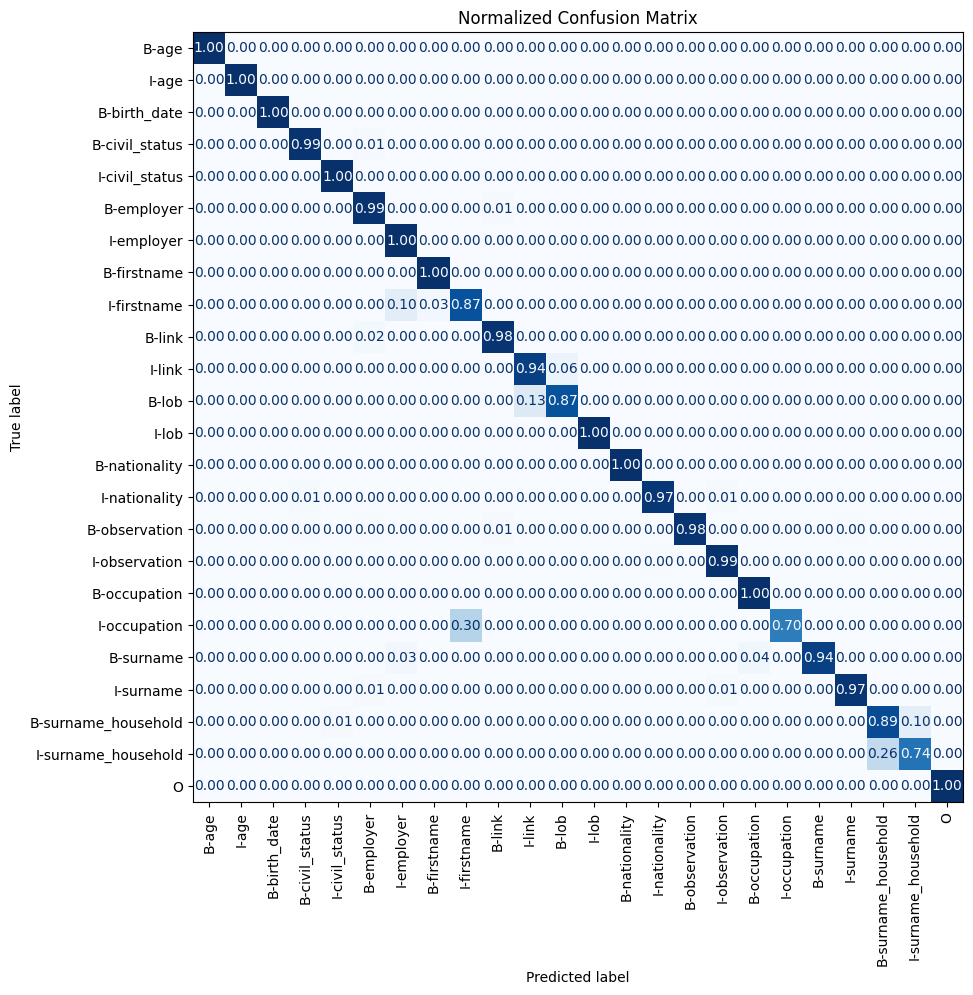

In [46]:
def plot_confusion_matrix(ytrue, ypreds, labels):
    cm = confusion_matrix(ytrue, ypreds, normalize="true")
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format="0.2f", ax=ax, colorbar=False)
    ax.set_xticklabels(labels, rotation=90)  # Rotation des labels en abscisse
    plt.title("Normalized Confusion Matrix")
    _ = plt.show()

flat_test_labels, flat_test_preds = [], []
for test_labels, test_preds in zip(test_labels_list, test_preds_list):
  flat_test_labels.extend(test_labels)
  flat_test_preds.extend(test_preds)
tag_names.remove("I-birth_date")
plot_confusion_matrix(flat_test_labels, flat_test_preds, tag_names)